In [85]:
import yfinance as yf
from pandas_datareader import data as pdr
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import dates

pd.set_option('display.width', 1000)

In [86]:
yf.pdr_override()

In [87]:
start = '2019-01-01'
data = pdr.get_data_yahoo('TSLA', start=start)
data.drop('Adj Close', axis=1, inplace=True)

[*********************100%***********************]  1 of 1 completed


In [88]:
data['Prev_close'] = data['Close'].shift()
data['Rate'] = (data['Close'] - data['Prev_close']) / data['Prev_close'] * 100
data['Rate'][0] = (data['Close'][0] - data['Open'][0]) / data['Open'][0] * 100
data['Rate'] = data['Rate'].round(decimals=2)

data.reset_index(inplace=True)
data['Date'] = data['Date'].dt.strftime('%Y-%m-%d')
data.set_index(data['Date'], inplace=True)
data.drop(['Date', 'Prev_close'], axis=1, inplace=True)

c:\Users\ozing\miniconda3\envs\RL_trader\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


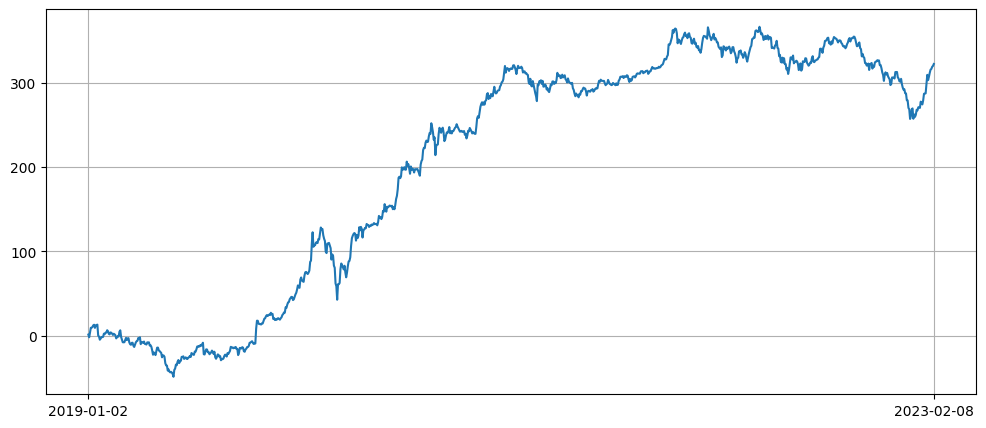

In [89]:
plt.figure(figsize=(12, 5))
plt.plot(data.index, data['Rate'].cumsum())
plt.grid()
# plt.xticks(rotation=90)
ax = plt.gca()
ax.xaxis.set_major_locator(dates.MonthLocator(interval=2))
ax.set_xticks([data.index[0], data.index[-1]])
plt.show()

In [90]:
window_size = 20
data_rolling = data['Close'].rolling(window_size, min_periods=1)
data[f'MA_{window_size}'] = data_rolling.mean().astype(np.int32)

In [91]:
data['Upper Band'] = data[f'MA_{window_size}'] + (2 * data_rolling.std())
data['Lower Band'] = data[f'MA_{window_size}'] - (2 * data_rolling.std())
data['Upper Band'][0] = data[f'MA_{window_size}'][0] + (2 * np.std([data['Open'][0], data['Close'][0]]))
data['Lower Band'][0] = data[f'MA_{window_size}'][0] - (2 * np.std([data['Open'][0], data['Close'][0]]))

data['Upper Band'] = data['Upper Band'].round(2)
data['Lower Band'] = data['Lower Band'].round(2)

c:\Users\ozing\miniconda3\envs\RL_trader\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
c:\Users\ozing\miniconda3\envs\RL_trader\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


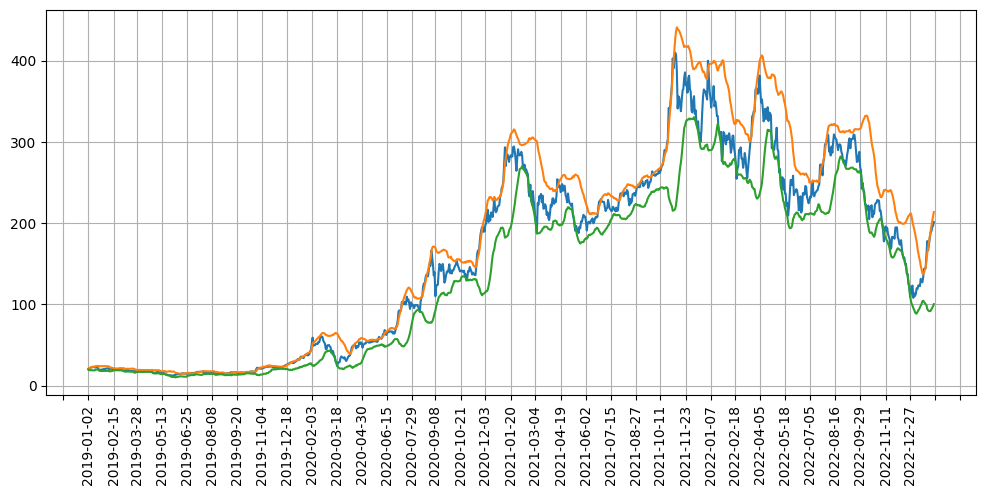

In [92]:
plt.figure(figsize=(12, 5))
plt.plot(data.index, data['Close'])
plt.plot(data.index, data['Upper Band'])
plt.plot(data.index, data['Lower Band'])
plt.grid()
plt.xticks(rotation=90)
ax = plt.gca()
ax.xaxis.set_major_locator(dates.MonthLocator(interval=1))
plt.show()

In [93]:
kospi = pdr.get_data_yahoo('^GSPC', start=start)

[*********************100%***********************]  1 of 1 completed


In [94]:
kospi.reset_index(inplace=True)
kospi['Date'] = kospi['Date'].dt.strftime('%Y-%m-%d')
kospi.set_index(kospi['Date'], inplace=True)
kospi.drop(['Date'], axis=1, inplace=True)

In [95]:
df = pd.concat([data, kospi['Close'].round(2)], axis=1)
df.columns = data.columns.append(pd.Index(['Kospi']))

In [96]:
df

,Open,High,Low,Close,Volume,Rate,MA_20,Upper Band,Lower Band,Kospi
Date,,,,,,,,,,
2019-01-02,20.406668,21.008667,19.920000,20.674667,174879000,1.31,20,20.27,19.73,2510.03
2019-01-03,20.466667,20.626667,19.825333,20.024000,104478000,-3.15,20,20.92,19.08,2447.89
2019-01-04,20.400000,21.200001,20.181999,21.179333,110911500,5.77,20,21.16,18.84,2531.94
2019-01-07,21.448000,22.449333,21.183332,22.330667,113268000,5.44,21,22.95,19.05,2549.69
2019-01-08,22.797333,22.934000,21.801332,22.356667,105127500,0.12,21,23.05,18.95,2574.41
...,...,...,...,...,...,...,...,...,...,...
2023-02-02,187.330002,196.750000,182.610001,188.270004,217448300,3.78,141,190.06,91.94,4179.76
2023-02-03,183.949997,199.000000,183.690002,189.979996,231684200,0.91,145,196.26,93.74,4136.48
2023-02-06,193.009995,198.169998,189.919998,194.759995,186188100,2.52,149,202.33,95.67,4111.08


In [97]:
df[df['Volume']==0]

,Open,High,Low,Close,Volume,Rate,MA_20,Upper Band,Lower Band,Kospi
Date,,,,,,,,,,


In [98]:
df_for_test = df.iloc[:, :5]
# df_for_test.replace(0, method='bfill', inplace=True)
# df_for_test.describe()

In [99]:
ticker = "TSLA"
stock_info = yf.Ticker(ticker)

In [100]:
stock_info.info['trailingPE']
stock_info.info['priceToBook']

Exception: yfinance failed to decrypt Yahoo data response

In [101]:
import tensorflow as tf
from keras.layers import Layer, Dropout, LayerNormalization, Conv1D, Concatenate, GlobalAveragePooling1D, Dense, Input
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint

batch_size = 32
seq_len = 40

# feature: Open, High, Low, Close, Volume(, Rate, MA_20, Upper Band, Lower Band, Kospi)
# periodic_feature = ['', '']
# non_periodic_feature = ['', '']

d_k = 256
d_v = 256
n_heads = 12
ff_dim = 256

class Time2Vector(Layer):
  def __init__(self, seq_len, **kwargs):
    super(Time2Vector, self).__init__()
    self.seq_len = seq_len

  def build(self, input_shape):
    self.weights_linear = self.add_weight(name='weight_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.bias_linear = self.add_weight(name='bias_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.weights_periodic = self.add_weight(name='weight_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

    self.bias_periodic = self.add_weight(name='bias_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

  def call(self, x):
    x = tf.math.reduce_mean(x[:,:,:4], axis=-1) # Convert (batch, seq_len, 5) to (batch, seq_len)
    time_linear = self.weights_linear * x + self.bias_linear
    time_linear = tf.expand_dims(time_linear, axis=-1) # (batch, seq_len, 1)
    
    time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
    time_periodic = tf.expand_dims(time_periodic, axis=-1) # (batch, seq_len, 1)
    return tf.concat([time_linear, time_periodic], axis=-1) # (batch, seq_len, 2)

class SingleAttention(Layer):
  def __init__(self, d_k, d_v):
    super(SingleAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v

  def build(self, input_shape):
    self.query = Dense(self.d_k, input_shape=input_shape, kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform')
    self.key = Dense(self.d_k, input_shape=input_shape, kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform')
    self.value = Dense(self.d_v, input_shape=input_shape, kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform')

  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    q = self.query(inputs[0])
    k = self.key(inputs[1])

    attn_weights = tf.matmul(q, k, transpose_b=True)
    attn_weights = tf.map_fn(lambda x: x/np.sqrt(self.d_k), attn_weights)
    attn_weights = tf.nn.softmax(attn_weights, axis=-1)
    
    v = self.value(inputs[2])
    attn_out = tf.matmul(attn_weights, v)
    return attn_out 


class MultiAttention(Layer):
  def __init__(self, d_k, d_v, n_heads):
    super(MultiAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.attn_heads = list()

  def build(self, input_shape):
    for n in range(self.n_heads):
      self.attn_heads.append(SingleAttention(self.d_k, self.d_v))  
    self.linear = Dense(7, input_shape=input_shape, kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform')

  def call(self, inputs):
    attn = [self.attn_heads[i](inputs) for i in range(self.n_heads)]
    concat_attn = tf.concat(attn, axis=-1)
    multi_linear = self.linear(concat_attn)
    return multi_linear 

class TransformerEncoder(Layer):
  def __init__(self, d_k, d_v, n_heads, ff_dim, dropout=0.1, **kwargs):
    super(TransformerEncoder, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.ff_dim = ff_dim
    self.attn_heads = list()
    self.dropout_rate = dropout

  def build(self, input_shape):
    self.attn_multi = MultiAttention(self.d_k, self.d_v, self.n_heads)
    self.attn_dropout = Dropout(self.dropout_rate)
    self.attn_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)

    self.ff_conv1D_1 = Conv1D(filters=self.ff_dim, kernel_size=1, activation='relu')
    self.ff_conv1D_2 = Conv1D(filters=7, kernel_size=1) # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1]=7 
    self.ff_dropout = Dropout(self.dropout_rate)
    self.ff_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)    
  
  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    attn_layer = self.attn_multi(inputs)
    attn_layer = self.attn_dropout(attn_layer)
    attn_layer = self.attn_normalize(inputs[0] + attn_layer)

    ff_layer = self.ff_conv1D_1(attn_layer)
    ff_layer = self.ff_conv1D_2(ff_layer)
    ff_layer = self.ff_dropout(ff_layer)
    ff_layer = self.ff_normalize(inputs[0] + ff_layer)
    return ff_layer 

def create_model():
  '''Initialize time and transformer layers'''
  time_embedding = Time2Vector(seq_len)
  attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  # attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  # attn_layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)

  '''Construct model'''
  in_seq = Input(shape=(seq_len, 5))
  x = time_embedding(in_seq)
  x = Concatenate(axis=-1)([in_seq, x])
  x = attn_layer1((x, x, x))
  # x = attn_layer2((x, x, x))
  # x = attn_layer3((x, x, x))
  x = GlobalAveragePooling1D(data_format='channels_first')(x)
  x = Dropout(0.1)(x)
  x = Dense(64, activation='relu')(x)
  x = Dropout(0.1)(x)
  out = Dense(1, activation='linear')(x)

  model = Model(inputs=in_seq, outputs=out)
  model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mape'])
  return model

# for col in df_for_test.columns:
#     i = df_for_test[col].min()
#     a = df_for_test[col].max()
#     df_for_test[col] = (df_for_test[col]-i) / (a-i)

X_train, y_train = [], []
for i in range(seq_len, len(df_for_test)):
  X_train.append(df_for_test[i-seq_len:i]) # Chunks of training data with a length of 128 df-rows
  y_train.append(df_for_test.iloc[:, 3][i]) #Value of 4th column (Close Price) of df-row 128+1
X_train, y_train = np.array(X_train, dtype=np.float32), np.array(y_train, dtype=np.float32)

finance_feature = [8.61, 1.08, 13.42]

transformer = create_model()

es = EarlyStopping(monitor='mape', patience=2)
# mc = ModelCheckpoint('./model/train/{epoch:2d}_{mape:.4f}.h5', monitor='mape')
history = transformer.fit(X_train, y_train, batch_size=batch_size, epochs=100, callbacks=[es])

Epoch 1/100
32/32 [==============================] - 18s 341ms/step - loss: 39954.7031 - mae: 164.3589 - mape: 99.5525
Epoch 2/100
32/32 [==============================] - 11s 342ms/step - loss: 39393.7852 - mae: 162.6271 - mape: 96.3441
Epoch 3/100
32/32 [==============================] - 11s 345ms/step - loss: 37639.5898 - mae: 157.0458 - mape: 86.0021
Epoch 4/100
32/32 [==============================] - 11s 339ms/step - loss: 33889.6523 - mae: 146.2715 - mape: 73.6926
Epoch 5/100
32/32 [==============================] - 11s 339ms/step - loss: 27895.7266 - mae: 133.6758 - mape: 88.7095
Epoch 6/100
32/32 [==============================] - 11s 344ms/step - loss: 20877.1094 - mae: 120.1160 - mape: 122.6391


32/32 [==============================] - 5s 121ms/step


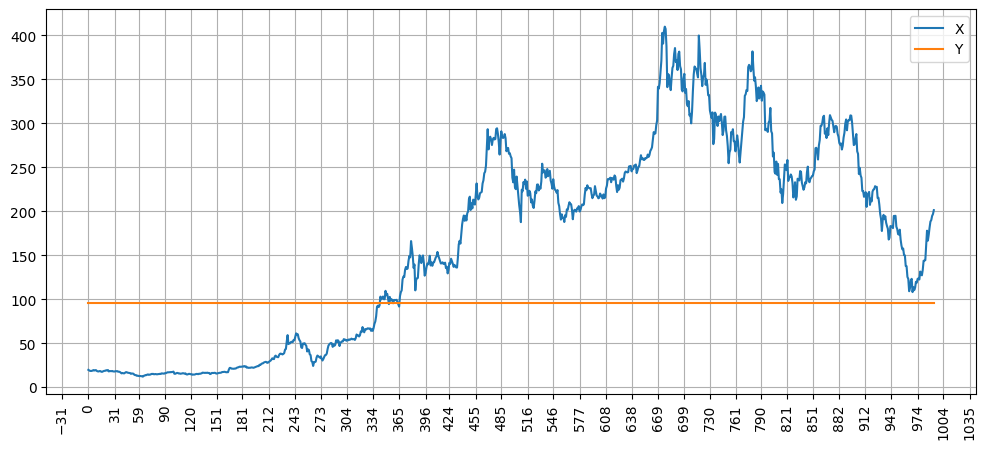

In [102]:
plt.figure(figsize=(12, 5))
plt.plot(y_train, label='X')
plt.plot(transformer.predict(X_train), label='Y')
plt.grid()
plt.legend()
plt.xticks(rotation=90)
ax = plt.gca()
ax.xaxis.set_major_locator(dates.MonthLocator(interval=1))
plt.show()